In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv('data.csv')
raw_data.head(10)

,image_file,rating
0,36.png,7.660000
1,37.png,7.200000
2,38.png,7.600000
3,39.png,7.866667
4,40.png,7.750000
5,41.png,8.166667
6,42.png,8.066667
7,43.png,7.866667
8,44.png,7.730000
9,45.png,6.800000


In [3]:
def generate_filename_lists(raw_data):
    raw_data['image_path'] = './images-data/' + raw_data['image_file']
    return raw_data

In [4]:
raw_data = generate_filename_lists(raw_data)

In [5]:
raw_data.head(10)

,image_file,rating,image_path
0,36.png,7.660000,./images-data/36.png
1,37.png,7.200000,./images-data/37.png
2,38.png,7.600000,./images-data/38.png
3,39.png,7.866667,./images-data/39.png
4,40.png,7.750000,./images-data/40.png
5,41.png,8.166667,./images-data/41.png
6,42.png,8.066667,./images-data/42.png
7,43.png,7.866667,./images-data/43.png
8,44.png,7.730000,./images-data/44.png
9,45.png,6.800000,./images-data/45.png


In [6]:
def resizing_all_images(image_paths, max_width):
    for image_path in image_paths:
        orig_image = cv2.imread(image_path)
        h, w, depth = orig_image.shape
        if w > max_width:
            scale = max_width / w
            new_h, new_w = orig_image.shape[0] * scale, orig_image.shape[1] * scale
            new_image = cv2.resize(orig_image, (int(new_w), int(new_h)))
            cv2.imwrite(image_path, new_image)

In [7]:
resizing_all_images(raw_data['image_path'].tolist(), 500)

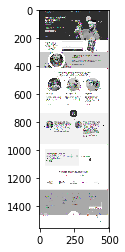

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('./images-data/52.png')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(gray,None)
img=cv2.drawKeypoints(gray,kp,img)
plt.imshow(img)

In [9]:
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler

class DescriptorHelper():
    
    def __init__(self, n_features):
        self.sift = cv2.xfeatures2d.SIFT_create(n_features)
        
    def gray(self, image):
        return cv2.cvtColor(image,cv.COLOR_BGR2GRAY)
        
    def features(self, image):
        keypoints, descriptor = self.sift.detectAndCompute(image, None)
        return [keypoints, descriptor]
    
    def to_vstack(self, desc_lists):
        """	
        restructures list into vstack array of shape
        M samples x N features for sklearn
        """
        vStack = np.array(desc_lists[0])
        for remaining in desc_lists[1:]:
            vStack = np.vstack((vStack, remaining))
        return vStack

class BagOfVisualWords():
    
    def __init__(self, raw_data, n_features_per_image):
        self.raw_data = raw_data
        self.n_features_per_image = n_features_per_image
        self.image_lists = self.get_image_lists()
        self.labels = []
        self.descriptor_lists = []
        self.descriptor_labels = []
        self.descriptor_index = []
        self.descriptor_vstack = None
        self.dc_helper = DescriptorHelper(self.n_features_per_image)
        
    def get_image_lists(self):
        image_paths = self.raw_data['image_path'].tolist()
        image_rating = self.raw_data['rating'].tolist()
        result = []
        for image_path, rating in zip(image_paths, image_rating):
            result.append((image_path, rating))
        return result

    def get_descriptor_vstack(self):
        return self.descriptor_vstack
        
    def get_histogram(self, k_means_ret, n_cluster_features):
        histogram  = np.array([np.zeros(n_cluster_features) for i in range(len(self.image_lists))])
        for i in range(len(self.descriptor_vstack)):
            index = self.descriptor_index[i]
            label = self.descriptor_labels[i]
            cls = k_means_ret[i]
            histogram[index][cls] += 1
        columns = ['feature_' + str(j) for j in range(n_cluster_features)]
        df = pd.DataFrame(data=histogram, columns=columns)
        ratings = []
        paths = []
        for image_path, rating in self.image_lists:
            ratings.append(rating)
            paths.append(image_path)
        df['image_path'] = pd.DataFrame(data=paths)
        df['rating'] = pd.DataFrame(data=ratings)
        return df
    
    def get_normalized_histogram_tf_idf(self, histogram):
        tf_idf = TfidfTransformer()
        df = histogram.drop(['rating', 'image_path'], axis=1)
        normalized_histogram = pd.DataFrame(data=tf_idf.fit_transform(df).toarray())
        normalized_histogram['rating'] = histogram['rating']
        normalized_histogram['image_path'] = histogram['image_path']
        return normalized_histogram
    
    def get_normalized_histogram_std(self, histogram):
        std = StandardScaler()
        df = histogram.drop(['rating', 'image_path'], axis=1)
        normalized_histogram = pd.DataFrame(data=std.fit_transform(df))
        normalized_histogram['rating'] = histogram['rating']
        normalized_histogram['image_path'] = histogram['image_path']
        return normalized_histogram
        
                                   
    def cluster_features(self, n_cluster_features):
        k_means = MiniBatchKMeans(n_clusters=n_cluster_features, tol=0.01)
        model = k_means.fit_predict(self.descriptor_vstack)
        return model
    
        
    def get_all_images_descriptor(self):
        count = 0
        total = 0
        for file_path, label in self.image_lists:
            img = cv2.imread(file_path)
            kp, des = self.dc_helper.features(img)
            if des is not None:
                self.descriptor_lists.append(des)
                for j in range(len(des)):
                    self.descriptor_labels.append(label)
                    self.descriptor_index.append(count)
                print('%d. Computing sift features for image %s generate %d features' % (count, file_path, len(des)))
                total += len(des)
            count = count + 1
        print(total)
        self.descriptor_vstack = self.dc_helper.to_vstack(np.array(self.descriptor_lists))
        return self.descriptor_vstack

In [10]:
MAX_N_FEATURES_PER_IMAGE = 2000
RANDOM_STATE = 10
bovw = BagOfVisualWords(raw_data, MAX_N_FEATURES_PER_IMAGE)
desc_lists = bovw.get_all_images_descriptor()


0. Computing sift features for image ./images-data/36.png generate 211 features
1. Computing sift features for image ./images-data/37.png generate 4 features
2. Computing sift features for image ./images-data/38.png generate 343 features
3. Computing sift features for image ./images-data/39.png generate 1132 features
4. Computing sift features for image ./images-data/40.png generate 390 features
5. Computing sift features for image ./images-data/41.png generate 23 features
6. Computing sift features for image ./images-data/42.png generate 31 features
7. Computing sift features for image ./images-data/43.png generate 79 features
9. Computing sift features for image ./images-data/45.png generate 51 features
10. Computing sift features for image ./images-data/46.png generate 1165 features
11. Computing sift features for image ./images-data/47.png generate 7 features
12. Computing sift features for image ./images-data/48.png generate 56 features
13. Computing sift features for image ./imag

109. Computing sift features for image ./images-data/148.png generate 1544 features
110. Computing sift features for image ./images-data/149.png generate 1 features
112. Computing sift features for image ./images-data/151.png generate 6 features
113. Computing sift features for image ./images-data/152.png generate 2001 features
114. Computing sift features for image ./images-data/153.png generate 2000 features
115. Computing sift features for image ./images-data/154.png generate 779 features
116. Computing sift features for image ./images-data/155.png generate 170 features
117. Computing sift features for image ./images-data/156.png generate 2000 features
118. Computing sift features for image ./images-data/157.png generate 12 features
119. Computing sift features for image ./images-data/158.png generate 32 features
121. Computing sift features for image ./images-data/160.png generate 34 features
123. Computing sift features for image ./images-data/162.png generate 11 features
124. Com

221. Computing sift features for image ./images-data/260.png generate 379 features
222. Computing sift features for image ./images-data/261.png generate 64 features
223. Computing sift features for image ./images-data/262.png generate 8 features
224. Computing sift features for image ./images-data/263.png generate 144 features
225. Computing sift features for image ./images-data/264.png generate 217 features
226. Computing sift features for image ./images-data/265.png generate 2000 features
227. Computing sift features for image ./images-data/266.png generate 203 features
228. Computing sift features for image ./images-data/267.png generate 2002 features
229. Computing sift features for image ./images-data/268.png generate 82 features
230. Computing sift features for image ./images-data/269.png generate 538 features
231. Computing sift features for image ./images-data/270.png generate 2000 features
232. Computing sift features for image ./images-data/271.png generate 4 features
233. Co

In [32]:
n_cluster = 70

cluster_ret = bovw.cluster_features(n_cluster)
histogram = bovw.get_histogram(cluster_ret, n_cluster)
normalized_histogram_tf_idf = bovw.get_normalized_histogram_tf_idf(histogram)
normalized_histogram_std = bovw.get_normalized_histogram_std(histogram)

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

clf = LinearRegression()
data = normalized_histogram_std

X = data.drop(['rating', 'image_path'], axis=1)
y = data['rating']

n_test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=n_test_size)
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [34]:
predicted = clf.predict(X_test)

In [35]:
result = pd.DataFrame()
result['predicted'] = predicted
result['target'] = y_test.tolist()
result

,predicted,target
0,7.340545,7.310000
1,7.523176,7.616667
2,7.653693,7.200000
3,7.494304,7.820000
4,7.485760,7.350000
5,7.383682,7.500000
6,7.465778,7.190000
7,7.698151,7.583333
8,7.476611,7.430000
9,7.456682,7.190000
